# Effective Receptive Field

In [1]:
from unet import UNet
from utils.config import load_config
from utils.metrics import dice_score
from trf import compute_trf
from matplotlib import pyplot as plt
from IPython.display import Image, display
from torch.utils.data import DataLoader
from train import SegmentationDataset
import matplotlib.patches as patches
import numpy as np
import torch
import glob
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

For U-Net, the ERF is input-dependent (rather than a function of its parameters) because of the max-pooling. In Luo's paper it is stated that the ERF is the partial derivative of the output w.r.t. the input, so I use torch.autograd to compute this. I compute this for every input image and take the average of all of them because if the input dependence.

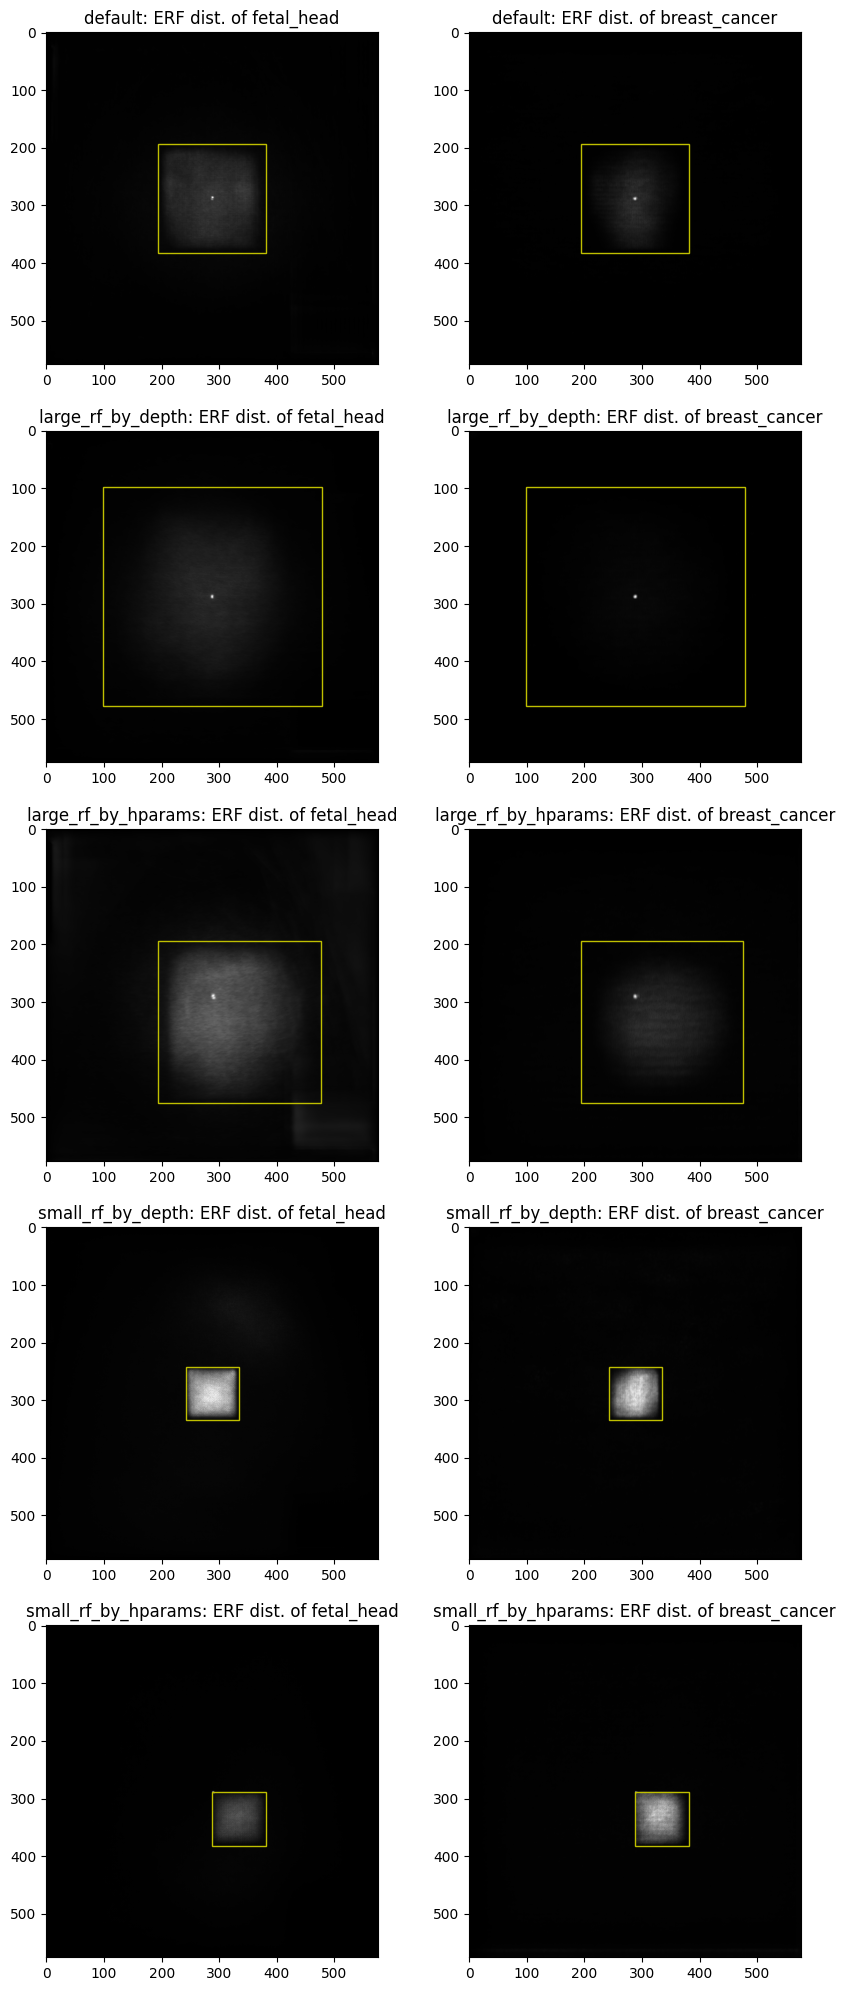

In [59]:
configs = ["default", "large_rf_by_depth", "large_rf_by_hparams", "small_rf_by_depth", "small_rf_by_hparams"]

fig, axs = plt.subplots(len(configs), 2, figsize=(10, 25))

for m, configname in enumerate(configs):

    config = load_config(configname)
    model = UNet(config).to(device)
    trf, pos = model.pixel_trf(576//2, 576//2), (576//2, 576//2)

    for n, dataset_name in enumerate(["fetal_head", "breast_cancer"]):
        model.load_state_dict(torch.load(f"results/{configname}/{dataset_name}_best_model.pt")["model_state_dict"])
        # model.eval()

        inputs = glob.glob(os.path.join(f"data/preprocessed/{dataset_name}/*", "*.png"))
        masks = glob.glob(os.path.join(f"data/preprocessed/{dataset_name}/*/masks", "*.png"))
        dataset_test = SegmentationDataset(inputs, masks)
        dataloader_test = DataLoader(dataset_test, shuffle=True)

        dist = np.zeros((576, 576, len(dataloader_test)))

        for i, (x, _) in enumerate(dataloader_test):
            x.requires_grad = True
            x = x.to(device)
            out = model(x)
            out_center = out[:, :, 288, 288]

            d = torch.autograd.grad(out_center, x)[0]
            
            # normalize for visualization
            d = torch.abs(d)
            d = (d - d.min()) / (d.max() - d.min())

            img = d.detach().cpu().numpy()
            img = np.squeeze(img)

            dist[:, :, i] = img


        img = np.mean(dist, axis=2)

        # plot ERF
        axs[m, n].imshow(img, cmap="gray")

        # plot TRF
        start = trf[0, 0], trf[0, 1]
        len_x = trf[1, 0] - trf[0, 0] + 1
        len_y = trf[1, 1] - trf[0, 1] + 1
        patch = patches.Rectangle(start, len_x, len_y, linewidth=1, edgecolor='y', facecolor='none')
        axs[m, n].add_patch(patch)

        axs[m, n].set_title(f"{configname}: ERF dist. of {dataset_name}")

    del model

    
plt.show()